In [68]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utils import RegressionAnalysis
from utils import CorrelationAnalysis
from utils import plot_linear_fit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay, precision_score, recall_score

In [2]:
m = pd.read_csv(r'../data/rotten_tomatoes_movies.csv')
cr = pd.read_csv(r'../data/rotten_tomatoes_critic_reviews.csv')
o = pd.read_csv(r'../data/the_oscar_award.csv')

In [3]:
o.head()

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False


Historically, are rotten tomatoes ratings good predictors of Oscar Success?

What defines Oscar Success?

Is winning Best Actor the same as Oscar Success for a film?

In [4]:
# Filter rotten tomatoes data to films for which we have Oscar data
o['wins'] = o['winner'].map(lambda x: 1 if x == True else 0, na_action='ignore')
o['losses'] = o['winner'].map(lambda x: 1 if x == False else 0, na_action='ignore')

In [5]:
wl_by_film = o.groupby('film')[['wins', 'losses']].sum()

In [6]:
movies_with_wl = pd.merge(m, wl_by_film, left_on='movie_title', right_on='film', how='left')

In [7]:
movies_with_wl['wins'] = movies_with_wl.wins.fillna(0)
movies_with_wl.losses = movies_with_wl.losses.fillna(0)

<AxesSubplot: xlabel='tomatometer_rating', ylabel='wins'>

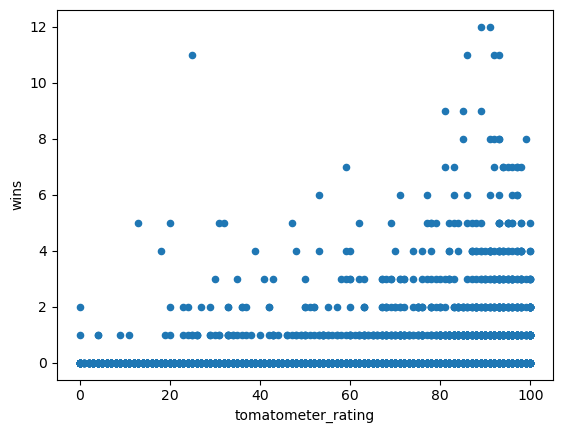

In [8]:
movies_with_wl.plot(x='tomatometer_rating', y='wins', kind='scatter')

In [9]:
movies_with_wl.tomatometer_rating.corr(movies_with_wl.wins)

0.12390018840502937

In [10]:
movies_with_wl.audience_rating.corr(movies_with_wl.wins)

0.15097447382970136

In [11]:
cr.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [12]:
cr[cr.review_score.notna()]

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
6,m/0814255,Nick Schager,False,Slant Magazine,Rotten,1/4,2010-02-10,Harry Potter knockoffs don't come more transpa...
7,m/0814255,Bill Goodykoontz,True,Arizona Republic,Fresh,3.5/5,2010-02-10,"Percy Jackson isn't a great movie, but it's a ..."
8,m/0814255,Jordan Hoffman,False,UGO,Fresh,B,2010-02-10,"Fun, brisk and imaginative"
9,m/0814255,Jim Schembri,True,The Age (Australia),Fresh,3/5,2010-02-10,"Crammed with dragons, set-destroying fights an..."
...,...,...,...,...,...,...,...,...
1130012,m/zulu_dawn,Chuck O'Leary,False,Fantastica Daily,Rotten,2/5,2005-11-02,NaN
1130013,m/zulu_dawn,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Fresh,3.5/5,2007-03-07,"Seen today, it's not only a startling indictme..."
1130014,m/zulu_dawn,Dennis Schwartz,False,Dennis Schwartz Movie Reviews,Fresh,B+,2010-09-16,A rousing visual spectacle that's a prequel of...
1130015,m/zulu_dawn,Christopher Lloyd,False,Sarasota Herald-Tribune,Rotten,3.5/5,2011-02-28,"A simple two-act story: Prelude to war, and th..."


In [13]:
cr[cr.review_score.isna()]

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...
5,m/0814255,David Germain,True,Associated Press,Rotten,NaN,2010-02-10,It's more a list of ingredients than a movie-m...
...,...,...,...,...,...,...,...,...
1129998,m/zulu,Variety Staff,True,Variety,Fresh,NaN,2009-01-02,Joseph E. Levine makes an impressive debut in ...
1130001,m/zulu,Kenneth Turan,True,Los Angeles Times,Fresh,NaN,2017-07-10,"This may not be exact history, but it certainl..."
1130003,m/zulu,Will Heaven,True,Daily Telegraph (UK),Fresh,NaN,2017-07-10,"It may not be truthful - but, my God, the resu..."
1130007,m/zulu,Isabel Quigly,False,The Spectator,Fresh,NaN,2020-03-11,"The tension mounts, breaks, mounts, seems unbe..."


In [14]:
def parse_frac_score(s):
    if '/' not in s:
        return -1
    
    spl = s.split('/')
    assert(len(spl) == 2)
    num = float(spl[0])
    den = float(spl[1])
    
    if den == 0:
        print(f"Den 0 for {s}")
        return -1
    
    return num/den

def parse_letter_score(s):
    max_score = ord('A')
    min_score = ord('F')
    mods = {
        '+': 0.5,
        '-': -0.5
    }
    
    if len(s) > 2 or len(s) < 1:
        return -1
    
    base = abs(ord(s[0]) - min_score)
    
    if len(s) == 2:
        if s[1] not in mods:
            return -1
        base += mods[s[1]]
        
    score = max(0, base)
    score = min(1, score)
    return score / abs(max_score - min_score)

def parse_score(s):
    s = s.replace(" ", "")
    ret = -1
    ret = parse_frac_score(s)
    
    if ret < 0:
        ret = parse_letter_score(s)
        
    if ret < 0:
        print(f"Score {s} cannot be parsed")
        return np.nan
    return ret

In [15]:
cr['norm_score'] = cr.review_score.map(parse_score, na_action='ignore')

Score 10 cannot be parsed
Score 10 cannot be parsed
Score 10 cannot be parsed
Score 25 cannot be parsed
Score 88 cannot be parsed
Score 48 cannot be parsed
Score 10 cannot be parsed
Score 10 cannot be parsed
Score 45 cannot be parsed
Score 10 cannot be parsed
Score 10 cannot be parsed
Score 10 cannot be parsed
Score 10 cannot be parsed
Score 10 cannot be parsed
Score 10 cannot be parsed
Den 0 for 61/00
Score 61/00 cannot be parsed
Score 24 cannot be parsed
Score 35 cannot be parsed
Score 10 cannot be parsed
Score 10 cannot be parsed
Score 10 cannot be parsed
Score 10 cannot be parsed
Score 10 cannot be parsed
Score 10 cannot be parsed
Score 46 cannot be parsed
Score 90 cannot be parsed
Score 75 cannot be parsed
Score 10 cannot be parsed
Score 45 cannot be parsed
Score 10 cannot be parsed
Score 89 cannot be parsed
Score 10 cannot be parsed
Score 34 cannot be parsed
Den 0 for 4/0
Score 4/0 cannot be parsed
Score 75 cannot be parsed
Score 75 cannot be parsed
Score 25 cannot be parsed
Scor

In [16]:
# Drop na norm_scores, this is a small portion of rows that have a review_score
cr = cr.dropna(subset = ['norm_score'])

In [17]:
cr.groupby('rotten_tomatoes_link')['norm_score'].skew()

rotten_tomatoes_link
m/+_one_2019                      -1.236432
m/+h                               1.925777
m/-_man                           -0.468868
m/-cule_valley_of_the_lost_ants   -1.502787
m/0814255                         -0.360320
                                     ...   
m/zoot_suit                        0.000000
m/zootopia                        -1.193656
m/zorba_the_greek                 -1.213827
m/zulu                            -1.069198
m/zulu_dawn                       -0.180715
Name: norm_score, Length: 17676, dtype: float64

In [18]:
avg_critic_scores = cr.groupby('rotten_tomatoes_link')['norm_score'].describe()
avg_critic_scores.head()

,count,mean,std,min,25%,50%,75%,max
rotten_tomatoes_link,,,,,,,,
m/+_one_2019,44.0,0.657955,0.217996,0.200,0.6,0.750,0.80000,0.95
m/+h,6.0,0.316667,0.250832,0.125,0.2,0.200,0.33125,0.80
m/-_man,32.0,0.537500,0.232362,0.000,0.4,0.600,0.75000,0.90
m/-cule_valley_of_the_lost_ants,7.0,0.671429,0.188982,0.300,0.6,0.800,0.80000,0.80
m/0814255,122.0,0.499590,0.188321,0.200,0.4,0.525,0.62500,0.80


In [19]:
data = pd.merge(movies_with_wl, avg_critic_scores[['mean', 'std', 'count', 'min', 'max']], on='rotten_tomatoes_link', how='left')
data = pd.merge(data, cr.groupby('rotten_tomatoes_link')['norm_score'].skew().rename('critic_skew').abs(), on='rotten_tomatoes_link', how='left')
data = data.rename({'mean': 'norm_score', 'std':'critic_std', 'count': 'critic_count', 'min': 'critic_min', 'max': 'critic_max'}, axis=1)
data['critic_range'] = data.critic_max - data.critic_min


In [20]:
data.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,tomatometer_rotten_critics_count,wins,losses,norm_score,critic_std,critic_count,critic_min,critic_max,critic_skew,critic_range
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,76,0.0,0.0,0.499590,0.188321,122.0,0.2,0.8,0.360320,0.6
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,19,0.0,0.0,0.655716,0.251823,102.0,0.2,1.0,0.875995,0.8
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,8,0.0,2.0,0.615476,0.245519,21.0,0.2,1.0,0.332465,0.8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,0,0.0,0.0,0.830349,0.269696,43.0,0.2,1.0,1.774797,0.8
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,3,0.0,0.0,0.742105,0.214258,19.0,0.2,1.0,0.844621,0.8


In [21]:
data.norm_score.corr(data.wins)

0.18324196745117122

<AxesSubplot: xlabel='norm_score', ylabel='wins'>

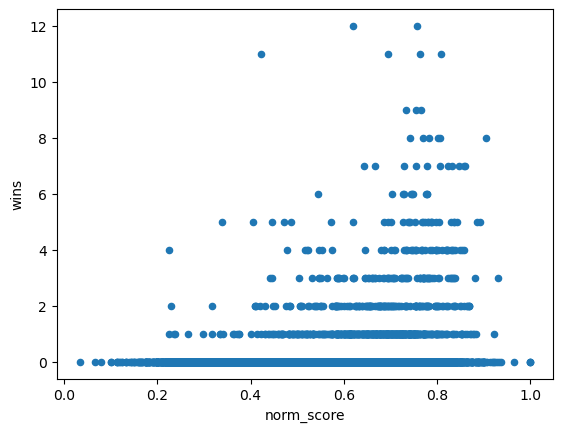

In [22]:
data.plot(x='norm_score', y='wins', kind='scatter')

<AxesSubplot: ylabel='Frequency'>

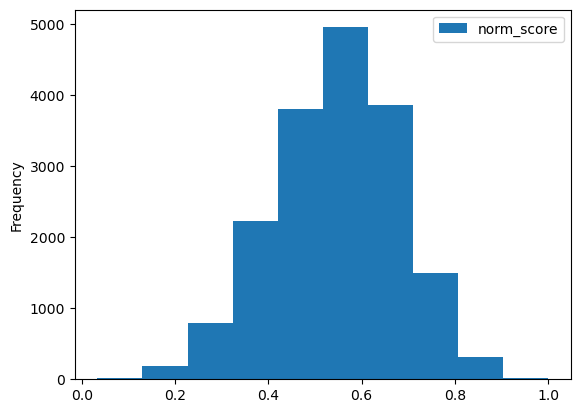

In [23]:
data.plot(y='norm_score', kind='hist')

<AxesSubplot: ylabel='Frequency'>

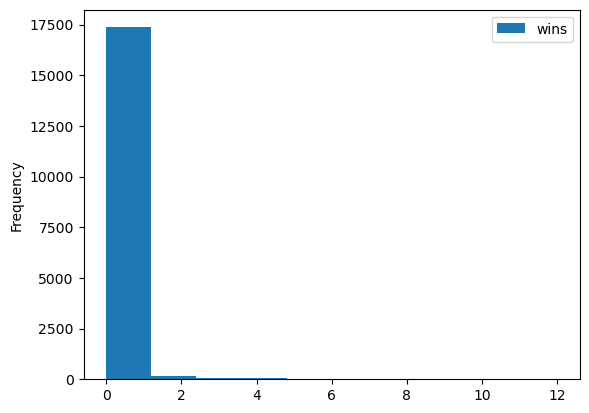

In [24]:
data.plot(y='wins', kind='hist')

In [25]:
data['success'] = data.wins > 0

array([<AxesSubplot: title={'center': 'False'}, ylabel='Frequency'>,
       <AxesSubplot: title={'center': 'True'}, ylabel='Frequency'>],
      dtype=object)

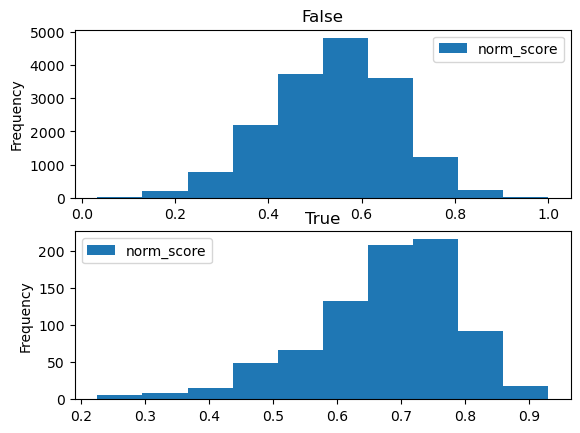

In [26]:
data.plot.hist(column=['norm_score'], by='success')

<AxesSubplot: title={'center': 'norm_score'}, xlabel='wins'>

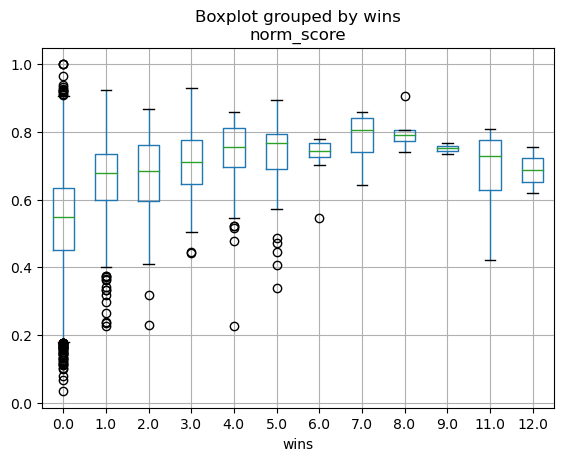

In [27]:
data.boxplot(column='norm_score', by='wins')

Determining if rotten tomato scores are good predictors of Oscar Success:

Aspects of Rotten Tomato Score

    1. Audience Rating
    2. Critics Fresh/Rotten 
    3. Critic specific scores from critics file
    
Metrics of Success

    1. Number of Oscars won by the movie (More being more success) - Linear Regression Analysis
    2. Winning any Oscar Award (Bool winning or not winning) - Logistic Regression Analysis
    
The analysis can then be broken down to all Oscar categories and per category to see if ratings are predictors of some categories but not others.
    


In [28]:
# Remove superfluous columns and rows that are missing data
regression_data = data.drop(
    [
        'movie_info', 
        'critics_consensus',
        'content_rating',
        'genres',
        'directors',
        'authors',
        'actors',
        'original_release_date',
        'streaming_release_date',
        'runtime',
        'production_company'
    ], axis=1).dropna()

In [29]:
def tts(X, y, random_state = 123, test_size=.25):
    '''
    split data for linear/logistic regression analysis
    
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    if X_train.ndim == 1:
        X_train = X_train.reshape(-1, 1)
        
    if X_test.ndim == 1:
        X_test = X_test.reshape(-1, 1)
        
    return X_train, X_test, y_train, y_test
    

    

In [30]:
regression_data[regression_data.tomatometer_rating.isna()]

,rotten_tomatoes_link,movie_title,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,...,wins,losses,norm_score,critic_std,critic_count,critic_min,critic_max,critic_skew,critic_range,success


In [31]:
# Setup train test split, since we aren't looking to make a generalized model just look for historic prediction power
# Don't necessarily need a test set
X_train, X_test, y_train, y_test = tts(regression_data.tomatometer_rating, regression_data.wins)

In [32]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [33]:
lr.score(X_train, y_train)

0.014879013161255172

In [34]:
lr.score(X_test, y_test)

0.019812771072533875

In [35]:
y_pred = lr.predict(X_test)

In [36]:
mean_absolute_error(y_pred, y_test)

0.1868134394753603

In [37]:
mean_squared_error(y_pred, y_test)

0.3376935078314199

<class 'numpy.ndarray'>
(4222, 1)


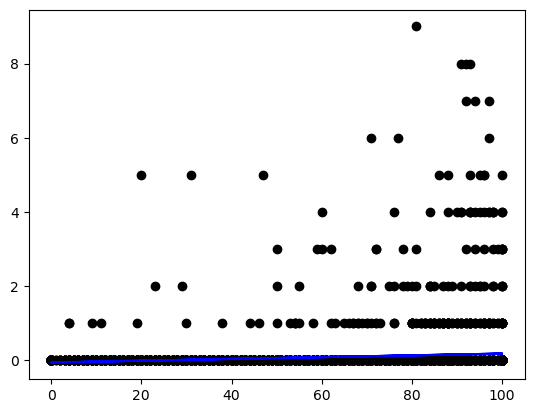

In [38]:
print(type(X_test))
print(X_test.shape)
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue')
plt.show()

What does it mean for X to be a predictor of y?

    1. That the two variables are correlated (Not really what predictor means)
    2. There is a direct causal relationship i.e linear regression analysis
    3. The various values of y come from different distributions of X i.e T-tests

### Correlation Analysis

In [39]:
data.columns

Index(['rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'wins', 'losses', 'norm_score', 'critic_std', 'critic_count',
       'critic_min', 'critic_max', 'critic_skew', 'critic_range', 'success'],
      dtype='object')

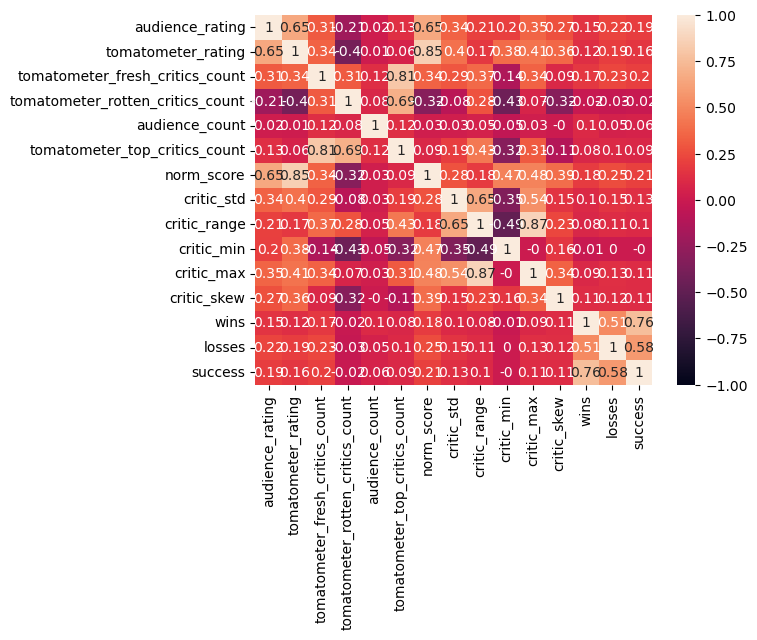

In [40]:
corr_analysis = CorrelationAnalysis(data)
corr_analysis.plot_heatmap(['audience_rating', 'tomatometer_rating', 'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count', 'audience_count', 'tomatometer_top_critics_count', 'norm_score', 'critic_std', 'critic_range', 'critic_min', 'critic_max', 'critic_skew', 'wins', 'losses', 'success'])

In [41]:
#1. Is there correlation between audience rating and the number of Oscar awards a movie wins?
corr_analysis.corr_coef('audience_rating', 'wins')

0.15097447382970136

In [42]:
#2. Is there a correlation between tomatometer rating and the number of Oscar awards a movie wins?
corr_analysis.corr_coef('tomatometer_rating', 'wins')

0.12390018840502937

In [43]:
#3. Is there a correlation between critic scores and the number of Oscar awards a movie wins?
corr_analysis.corr_coef('norm_score', 'wins')

0.18324196745117122

### Regression Analysis

In [44]:
'''
def plot_linear_fit(X, y_pred, y_test):
    plt.scatter(X, y_test, color='black')
    plt.scatter(X, y_pred, color='blue', marker='.')
    plt.show()
'''

"\ndef plot_linear_fit(X, y_pred, y_test):\n    plt.scatter(X, y_test, color='black')\n    plt.scatter(X, y_pred, color='blue', marker='.')\n    plt.show()\n"

In [45]:
#1. Regresion Analysis using number of awards won as measure of success
lra_wins = RegressionAnalysis(regression_data.drop(['wins', 'losses', 'success'], axis=1), regression_data.wins, False, scaler=RobustScaler())

0.02752910310634582


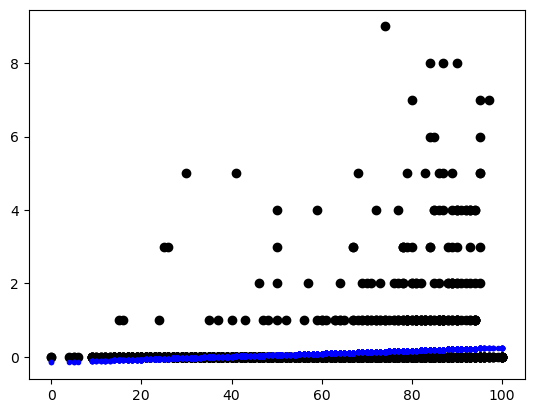

In [46]:
#1.1 Do audience ratings have a causal relationship with the number of Oscar awards a movie wins?
lra_wins.set_X_cols(['audience_rating'])
lra_wins.fit_train()
print(lra_wins.score_test())
plot_linear_fit(lra_wins.X_test(), lra_wins.predict_test(), lra_wins.y_test_)

0.019812771072533875


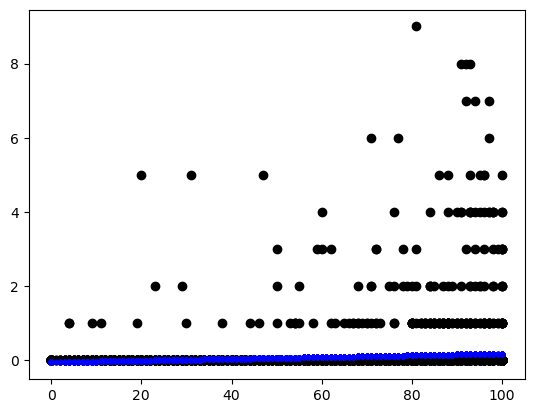

In [47]:
#1.2 Do tomatometer_ratings have a causal relationship with the number of Oscar awards a movie wins?
lra_wins.set_X_cols(['tomatometer_rating'])
lra_wins.fit_train()
print(lra_wins.score_test())
plot_linear_fit(lra_wins.X_test(), lra_wins.predict_test(), lra_wins.y_test_)

0.044421826809508125


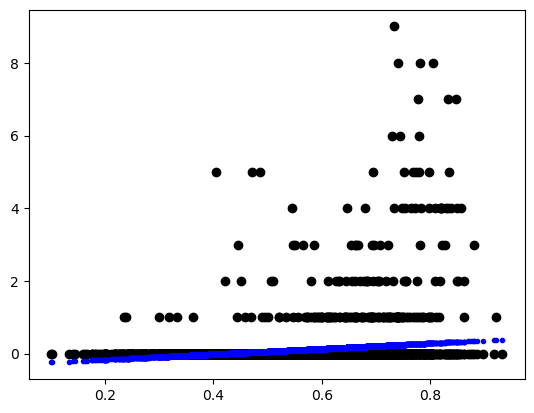

In [48]:
#1.3 Do critic scores have a causal relationship with the number of Oscar awards a movie wins?
lra_wins.set_X_cols(['norm_score'])
lra_wins.fit_train()
print(lra_wins.score_test())
plot_linear_fit(lra_wins.X_test(), lra_wins.predict_test(), lra_wins.y_test_)

0.07007278883377344
[ 0.12783304  0.00494723 -0.03066496 -0.08874626  0.06457854  0.03426236
  0.04199828 -0.00324698  0.01912799]


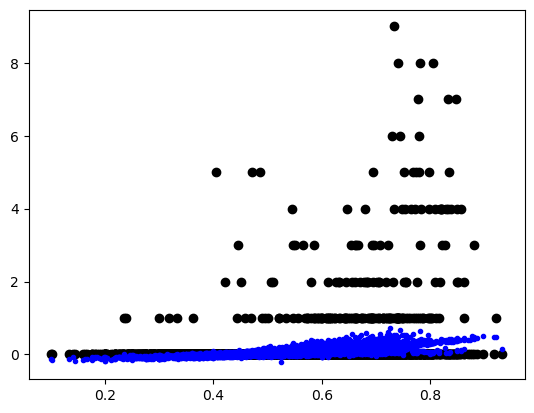

In [55]:
#1.3 Do critic scores have a causal relationship with the number of Oscar awards a movie wins?
lra_wins.set_X_cols(['norm_score', 'critic_std', 'critic_min', 'critic_max', 'critic_range', 'critic_skew', 'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count', 'audience_rating'])
lra_wins.fit_train()
print(lra_wins.score_test())
print(lra_wins.model_.coef_)
plot_linear_fit(lra_wins.X_test()[:, 0], lra_wins.predict_test(), lra_wins.y_test_)

### Regression Analysis on Winning Any Oscar Awards

Define success as winning any Oscar award and recheck using Logistic Regression as a classification problem

This approach runs into class imbalance right away that needs to be addressed before an accurate assessment can be made

In [50]:
lga = RegressionAnalysis(regression_data.drop(['wins', 'losses', 'success'], axis=1), regression_data.success, True, scaler=RobustScaler())

0.649928943628612


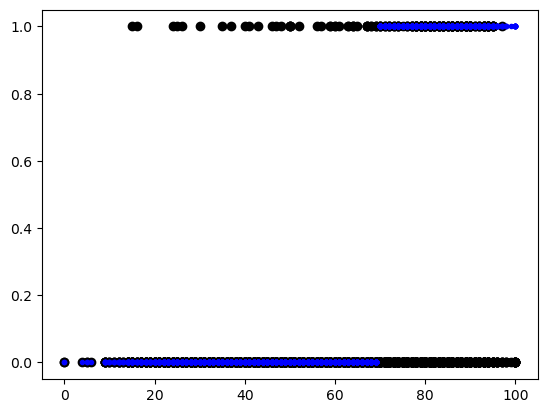

In [51]:
# audience score
lga.set_X_cols(['audience_rating'])
lga.fit_train()
print(lga.score_test())
plot_linear_fit(lga.X_test(), lga.predict_test(), lga.y_test_)

0.6084793936522975


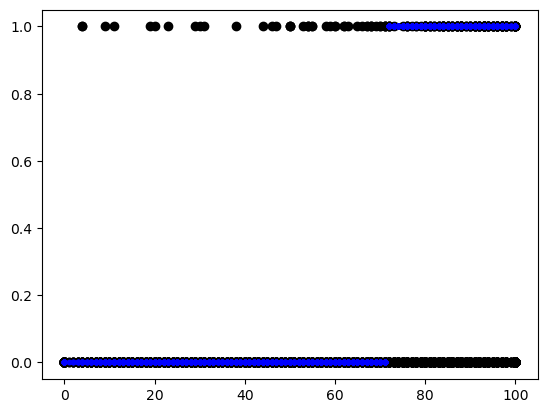

In [52]:
# tomatometer score
lga.set_X_cols(['tomatometer_rating'])
lga.fit_train()
print(lga.score_test())
plot_linear_fit(lga.X_test(), lga.predict_test(), lga.y_test_)

0.7051160587399337


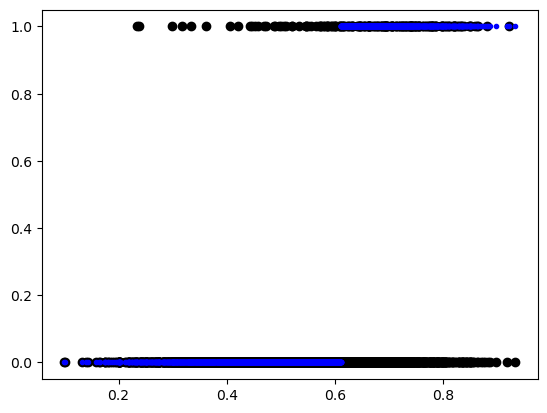

In [53]:
# average critic score
lga.set_X_cols(['norm_score'])
lga.fit_train()
print(lga.score_test())
plot_linear_fit(lga.X_test(), lga.predict_test(), lga.y_test_)

0.7316437707247749


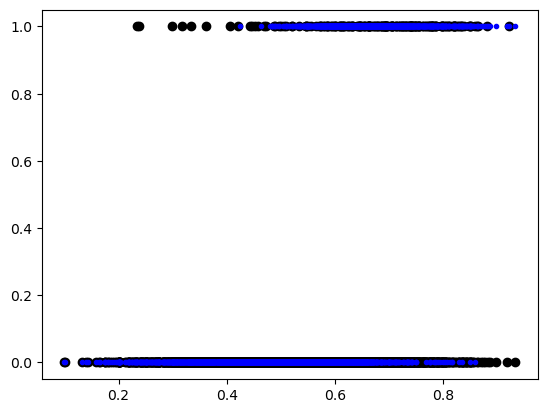

In [54]:
# average critic score
lga.set_X_cols(['norm_score', 'critic_std', 'critic_min', 'critic_max', 'critic_range', 'critic_skew', 'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count', 'audience_rating'])
lga.fit_train()
print(lga.score_test())
plot_linear_fit(lga.X_test()[:, 0], lga.predict_test(), lga.y_test_)

In [56]:
lga.model_.coef_

array([[ 1.33976518,  0.30880832, -0.14507102, -0.41699049,  0.39260527,
        -0.16274783,  0.06201615,  0.1115664 ,  0.74077302]])

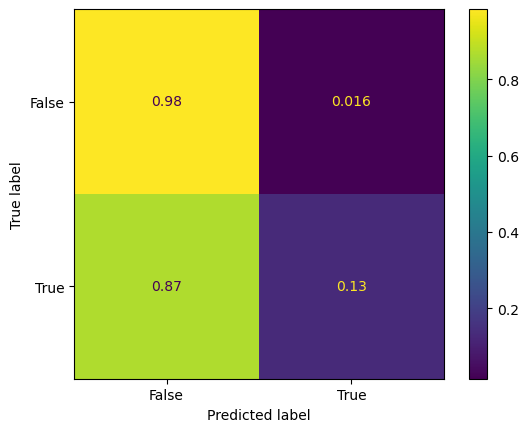

In [71]:
ConfusionMatrixDisplay.from_predictions(lga.predict_test(), lga.y_test_, normalize='true')

In [69]:
precision_score(lga.predict_test(), lga.y_test_)

0.7761904761904762

In [70]:
recall_score(lga.predict_test(), lga.y_test_)

0.13050440352281825